# Method

In this notebook I predict the future number of COVID-19 cases and deaths at an Area\* level, and use the parameters of the models used to infer to what extent key factors influence the rate of spread, reach, longevity, fatality rate and mortality of the virus. This information can hopefully be used to help mitigate the impact of COVID-19. These are the key steps in the approach: 

1. Fit a logistic curve to the cumulative daily cases and deaths for each Area with a reasonable amount of historic data.
1. Model the parameters of the fits using Area metadata in order to:
    * predict cases and deaths curve parameters in areas with low levels of historic data.
    * assess the influence of factors on the rate of spread, reach, longevity, fatality rate and mortality.
1. Calculate the residuals of the deths and cases fits over time to assess the influence of changing factors (for example: levels of testing and restrictions on movement).
1. Use these models to create a competition submission for testing.

\* An Area is defined as a Country/Region-State/Province pair (for example: *China-Hubei*, *United States-Texas*, or *Iran-nan*)  
  
  
### Logistic Curve Fitting

The logistic curves fitted for cases and deaths prediction were of the following form (where $y_c$ and $y_d$ are the cumulative cases and deaths respectively):  
## **$y_c = \frac{yc_{max}}{1 + e^{-kc(xc-xc_0)}}\;\;\;\;\;\;\;\;y_d = \frac{yd_{max}}{1 + e^{-kd(xd-xd_0)}}$**  


The parameters of these fits were translated into the following tangable parameters to get maximum insight:  
  
  
**Reach = $yc_{max}\;/\;population$**  
(the final expected number of cumulative cases as a proportion of the population)  

**Longevity = $2*ln(yc_{max}-1)\;/\;kc$**  
(the time from the first new case to the last new case)  

**Rate of Spread = $kc*yc_{max}\;/\;4*population$**  
(maximum number of new cases per day as a proportion of the population)  

**Mortality = $yd_{max}\;/\;population$**  
(the final expected number of cumulative deaths as a proportion of the population)    
  
**Fatality Rate = $yc_{max}\;/\;yd_{max}$**  
(the final expected number of cumulative deaths per confirmed case)

Example curves demonstrating the tangable parameters:   
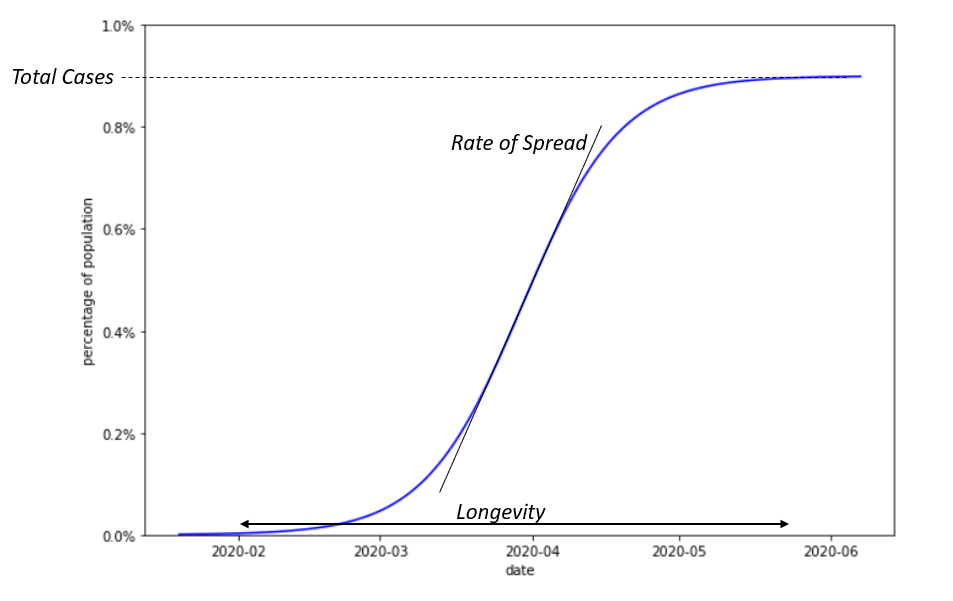  
  

  
    
    
Thanks to the following sources for helping inform this analysis:  
The *scipy.optimize.curve_fit* package was used to impliment the fit using non-linear least squares, as explored by *Daner Ferhadi* [here](https://www.kaggle.com/dferhadi/logistic-curve-fitting-global-covid-19-confirmed/).  
The Area metadata used was gathered by *My Koryto* [here](https://www.kaggle.com/koryto/countryinfo), and *hbFree* [here](https://www.kaggle.com/hbfree/covid19formattedweatherjan22march24).

# Summary of Key Factor that Influence Virus Impact

Several factors were found to have reasonable correlation with the impact of the virus, though none of the correlations were particularly strong. Faster enacted restrictions on movement have the biggest influence. Here are the main factors that were found to reduce the impact of COVID-19:

* **Schools Closed**
    * *on average* one day delay lengthens the impact by 1.1 days, and means means 110 more people per million will become confirmed cases
* **Public Venues Closed**
    * *on average* one day delay lengthens the impact by 2.0 days, and means means 140 more people per million will become confirmed cases
* **Social Gatherings Banned**
    * *on average* one day delay lengthens the impact by 2.1 days, and means means 150 more people per million will become confirmed cases
* **Non-Essential House Leaving Banned**
    * *on average* one day delay lengthens the impact by 3.0 days, and means means 150 more people per million will become confirmed cases
* **Higher temperature**
    * On average one degree celcius higher means 6 fewer people per million will become confirmed cases
* **Lower humidity**
    * On average one percentage lower humidity means 20 fewer people per million will become confirmed cases
* **Lower median age**
    * On average one year higher median age means 5 fewer people per million will become confirmed cases

# Fitting Logistic Curves
In this section the hisoric data is fitted to a logistic curve to predict future cases

In [ ]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import datetime 
from datetime import timedelta
import seaborn as sns
from sklearn import linear_model
%matplotlib inline

In [ ]:
# import raw competition data
competition_df = pd.read_csv("/kaggle/input/covid19-global-forecasting-week-4/train.csv")
competition_df['area'] = [str(i)+str(' - ')+str(j) for i,j in zip(competition_df['Country_Region'], competition_df['Province_State'])]
competition_df['Date'] = pd.to_datetime(competition_df['Date'])
competition_df.head()

In [ ]:
# fuction for extracting data by Area
def get_country_data(df, area, metric):
    area_data = df[df['area']==area]
    area_data = area_data.drop(['Id','Province_State', 'Country_Region'], axis=1)
    area_data = pd.pivot_table(area_data, values=['ConfirmedCases','Fatalities'], index=['Date'], aggfunc=np.sum) 
    area_data = area_data[area_data[metric]!=0]
    return area_data        

In [ ]:
# functions for fitting the curve
def log_curve(x, k, x_0, ymax):
    return ymax / (1 + np.exp(-k*(x-x_0)))

def log_fit(df, area, metric):
    area_data = get_country_data(df, area, metric)
    x_data = range(len(area_data.index))
    y_data = area_data[metric]
    period = len(y_data)
    if period < 1:
        estimated_k, estimated_x_0, ymax = np.nan, np.nan, np.nan 
        total = 0
    elif max(y_data) == 0:
        estimated_k, estimated_x_0, ymax = np.nan, np.nan, np.nan 
        total = 0
    else:
        total = max(y_data)
        try:
            popt, pcov = curve_fit(log_curve, x_data, y_data, bounds=([0,0,0],np.inf), p0=[0.3,100,10000], maxfev=1000000)
            estimated_k, estimated_x_0, ymax = popt
        except RuntimeError:
            print(area)
            print("Error - curve_fit failed") 
            estimated_k, estimated_x_0, ymax = np.nan, np.nan, np.nan 
    estimated_parameters = pd.DataFrame(np.array([[area, period, total, estimated_k, estimated_x_0, ymax]]),
                                        columns=['area', 'period', 'total', 'k', 'x_0', 'ymax'])
    return estimated_parameters

In [ ]:
# extracting the cases paramters for each Area
cases_parameters = pd.DataFrame(columns=['area', 'period', 'total', 'k', 'x_0', 'ymax'], dtype=np.float)
for area in competition_df['area'].unique():
    estimated_parameters = log_fit(competition_df, area, 'ConfirmedCases')
    cases_parameters = cases_parameters.append(estimated_parameters)
cases_parameter_names = ['k', 'x_0', 'ymax', 'Total Cases (absolute)', 'Longevity', 'Rate of Spread (absolute)']
cases_parameters['period'] = pd.to_numeric(cases_parameters['period'], downcast="float", errors='coerce')
cases_parameters['total'] = pd.to_numeric(cases_parameters['total'], downcast="float", errors='coerce')
cases_parameters['k'] = pd.to_numeric(cases_parameters['k'], downcast="float", errors='coerce')
cases_parameters['x_0'] = pd.to_numeric(cases_parameters['x_0'], downcast="float", errors='coerce')
cases_parameters['ymax'] = pd.to_numeric(cases_parameters['ymax'], downcast="float", errors='coerce')
cases_parameters['Total Cases (absolute)'] = cases_parameters['ymax']
cases_parameters['Longevity'] = 2*np.log(cases_parameters['ymax']-1) / cases_parameters['k']
cases_parameters['Rate of Spread (absolute)'] = cases_parameters['k']*cases_parameters['ymax']/4
cases_parameters.loc[(cases_parameters['total']<100) | (cases_parameters['period']<20), cases_parameter_names] = np.nan

In [ ]:
# extracting the deaths paramters for each Area
deaths_parameters = pd.DataFrame(columns=['area', 'period', 'total', 'k', 'x_0', 'ymax'], dtype=np.float)
for area in competition_df['area'].unique():
    estimated_parameters = log_fit(competition_df, area, 'Fatalities')
    deaths_parameters = deaths_parameters.append(estimated_parameters)
deaths_parameter_names = ['k', 'x_0', 'ymax', 'Mortality (absolute)', 'Fatality Rate']
deaths_parameters['period'] = pd.to_numeric(deaths_parameters['period'], downcast="float", errors='coerce')
deaths_parameters['total'] = pd.to_numeric(deaths_parameters['total'], downcast="float", errors='coerce')
deaths_parameters['k'] = pd.to_numeric(deaths_parameters['k'], downcast="float", errors='coerce')
deaths_parameters['x_0'] = pd.to_numeric(deaths_parameters['x_0'], downcast="float", errors='coerce')
deaths_parameters['ymax'] = pd.to_numeric(deaths_parameters['ymax'], downcast="float", errors='coerce')
deaths_parameters['Mortality (absolute)'] = deaths_parameters['ymax']
deaths_parameters['Fatality Rate'] = deaths_parameters['ymax'] / cases_parameters['ymax']
deaths_parameters.loc[(deaths_parameters['total']<100) | (deaths_parameters['period']<20), deaths_parameter_names] = np.nan
deaths_parameters.loc[deaths_parameters['Mortality (absolute)']>cases_parameters['Total Cases (absolute)'], deaths_parameter_names] = np.nan

In [ ]:
cases_parameters_orig = cases_parameters.copy()
deaths_parameters_orig = deaths_parameters.copy()
all_parameters = cases_parameters.merge(deaths_parameters, on='area')
all_parameters = all_parameters[['area', 'Total Cases (absolute)', 'Longevity', 'Rate of Spread (absolute)', 'Mortality (absolute)', 'Fatality Rate']]
all_parameters.head()

In [ ]:
# create fit prediction dataframe
raw_predictions = pd.DataFrame(columns = ['area', 'date', 'day_no', 'ConfirmedCases', 'Fatalities', 'FittedCases', 'FittedFatalities', 'CasesResiduals', 'FatalitiesResiduals'])
start = pd.to_datetime('22/01/2020')
numdays = 20*7
date_list = [start + datetime.timedelta(days=x) for x in range(numdays)]
for area in competition_df['area'].unique(): # ['United Kingdom - nan', 'Italy - nan', 'Iran - nan', 'China - Hubei']: #    
    area_cases_data = get_country_data(competition_df, area, 'ConfirmedCases')
    cases_start_date = area_cases_data.index.min()
    offset = (cases_start_date - start).days
    x_data_fit = [i-offset for i in range(numdays)]
    x_data_real = range(1,len(area_cases_data.index)+1)
    parameters = cases_parameters
    estimated_k = parameters[parameters['area']==area]['k']
    estimated_x_0 = parameters[parameters['area']==area]['x_0']
    estimated_ymax = parameters[parameters['area']==area]['ymax']
    cases_fitted = log_curve(x_data_fit, np.float64(estimated_k), np.float64(estimated_x_0), np.float64(estimated_ymax))
    
    area_deaths_data = get_country_data(competition_df, area, 'Fatalities')
    deaths_start_date = area_deaths_data.index.min()
    offset = (deaths_start_date - start).days
    x_data_fit = [i-offset for i in range(numdays)]
    x_data_real = range(1,len(area_deaths_data.index)+1)
    parameters = deaths_parameters
    estimated_k = parameters[parameters['area']==area]['k']
    estimated_x_0 = parameters[parameters['area']==area]['x_0']
    estimated_ymax = parameters[parameters['area']==area]['ymax']
    deaths_fitted = log_curve(x_data_fit, np.float64(estimated_k), np.float64(estimated_x_0), np.float64(estimated_ymax))
    
    area_predictions = pd.DataFrame(data={'area': [area]*numdays, 'date': date_list}) 
    area_predictions = area_predictions.merge(area_cases_data, left_on='date', right_index=True, how='left')
    area_predictions['FittedCases'] = cases_fitted
    area_predictions['FittedFatalities'] = deaths_fitted
    
    #area_predictions['Cases Residuals'] = np.log(cases_fitted)-np.log(area_predictions['ConfirmedCases'])
    #area_predictions['Fatalities Residuals'] = np.log(deaths_fitted)-np.log(area_predictions['Fatalities'])
    area_predictions['CasesResiduals'] = (cases_fitted-area_predictions['ConfirmedCases'])/np.float64(estimated_ymax)
    area_predictions['FatalitiesResiduals'] = (deaths_fitted-area_predictions['Fatalities'])/np.float64(estimated_ymax)
    area_predictions['day_no'] = area_predictions['date']-pd.to_datetime('22/01/2020')
    area_predictions['day_no'] = [i.days for i in area_predictions['day_no']]
    
    raw_predictions = raw_predictions.append(area_predictions, sort=False)
    

In [ ]:
raw_predictions.head()

In [ ]:
# plot some example raw prediction fits
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,20))
areas = ['United Kingdom - nan', 'Italy - nan', 'Iran - nan', 'China - Hubei', 'Albania - nan', 'Australia - Queensland']
axs = [ax1, ax2, ax3, ax4, ax5, ax6]
for i in range(len(areas)):
    area = areas[i]
    axs[i].set_title(area.replace("- nan", ""))
    area_predictions = raw_predictions[raw_predictions['area']==area]
    axs[i].plot(area_predictions['date'], area_predictions['FittedCases'], label='Fitted Cases', color='b')
    axs[i].plot(area_predictions['date'], area_predictions['ConfirmedCases'], 'o', label='Actual Cases', color='b')
    axs[i].plot(area_predictions['date'], area_predictions['FittedFatalities'], '-', label='Fitted Fatalities', color='r')
    axs[i].plot(area_predictions['date'], area_predictions['Fatalities'], 'o', label='Actual Fatalities', color='r')
    axs[i].legend()

# Correlations with Key Factors

In [ ]:
# import metadata and join to the parameter data
area_data = pd.read_csv("/kaggle/input/countryinfo/covid19countryinfo.csv")
area_data['area'] = [str(i)+str(' - ')+str(j) for i,j in zip(area_data['country'], area_data['region'])]

full_data = all_parameters.merge(area_data, on='area', how='left')
full_data['pop'] = pd.to_numeric(full_data['pop'].str.replace(',', ''), downcast="float")
full_data.head()

In [ ]:
# create the factors for correlation
full_data['firstcase'] = pd.to_datetime(full_data['firstcase'])
date_metrics = ['quarantine', 'schools', 'publicplace', 'gathering', 'nonessential']
for metric in date_metrics:
    full_data[metric] = pd.to_datetime(full_data[metric])
    new_metric = 'days_to_'+metric
    full_data[new_metric] = (full_data[metric]-full_data['firstcase']).dt.days
    #full_data[new_metric] = full_data[new_metric].fillna(full_data['Longevity'])
    
full_data['Tests per Citizen'] = 1/full_data['testpop']
full_data['Hospital Beds per Citizen'] = full_data['hospibed']/1000
full_data = full_data.rename(columns={"density": "Population Density", 
                                      "medianage": "Median Age", 
                                      "urbanpop": "Urban Poulation %", 
                                      "avgtemp": "Average Temperature", 
                                      "avghumidity": "Average Humidity"})

In [ ]:
# normalise metrics against Area population
norm_data = full_data.copy()
norm_data['Total Cases'] = norm_data['Total Cases (absolute)']/norm_data['pop']
norm_data.loc[norm_data['Total Cases']>0.1, 'Total Cases'] = np.nan
norm_data['Rate of Spread'] = norm_data['Rate of Spread (absolute)']/norm_data['pop']
norm_data['Mortality'] = norm_data['Mortality (absolute)']/norm_data['pop']
norm_data.head()

In [ ]:
cases_parameters = cases_parameters_orig.merge(norm_data[['area','Total Cases','Rate of Spread']], on='area', how='left')
deaths_parameters = deaths_parameters_orig.merge(norm_data[['area','Mortality']], on='area', how='left')

In [ ]:
# select the metrics and factors to correlate
metrics = ['Total Cases', 'Longevity', 'Rate of Spread', 'Mortality', 'Fatality Rate']
#, "Average Humidity", "Average Temperature"
factors = ['Total Cases', 'Longevity', 'Rate of Spread', 'Mortality', 'Fatality Rate', 'Tests per Citizen', 'Hospital Beds per Citizen', "Population Density", "Median Age", "Urban Poulation %", 'days_to_quarantine', 'days_to_schools', 'days_to_publicplace', 'days_to_gathering', 'days_to_nonessential']

In [ ]:
# calculate the correlation coefficient map 
corr_matrix = norm_data.corr(method ='spearman')
corr_matrix = corr_matrix[metrics].filter(factors, axis = 0)
cm = sns.diverging_palette(20, 133, sep=20, as_cmap=True)
corr_matrix.style.background_gradient(cmap=cm)

In [ ]:
# plot the correlations
for factor in factors:
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,5))
    axs = [ax1, ax2, ax3, ax4, ax5]
    x_data = norm_data[factor]
    for i in range(len(metrics)):
        metric = metrics[i]
        y_data = norm_data[metric]
        axs[i].set_title(metric+' vs '+factor)
        axs[i].plot(x_data, y_data, 'o')

In [ ]:
# calculate the slope map for significant correlation coefficients 
impact_matrix = norm_data.corr() * (norm_data.std().values / norm_data.std().values[:, np.newaxis])
impact_matrix = impact_matrix[metrics].filter(factors, axis = 0)
impact_matrix = impact_matrix*(abs(corr_matrix)>0.5)
cm = sns.diverging_palette(20, 133, sep=20, as_cmap=True)
impact_matrix.style.background_gradient(cmap=cm)

# Modelling using Key Factors
In this section the key factors are modeled to determine how they influence the Rate of Spread, Reach, Longevity, Death Rate and Death Toll

## Models Data Prep

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn import ensemble
from sklearn.metrics import mean_squared_error

In [ ]:
#, "Average Temperature", "Average Humidity"
features = ['pop', 'Tests per Citizen', 'Hospital Beds per Citizen', "Population Density", "Median Age", "Urban Poulation %", 'days_to_quarantine', 'days_to_schools', 'days_to_publicplace', 'days_to_gathering', 'days_to_nonessential']
norm_data[features].describe()

In [ ]:
#, "Average Temperature", "Average Humidity"
features = ['pop', 'Tests per Citizen', 'Hospital Beds per Citizen', "Population Density", "Median Age", "Urban Poulation %"]
models_df = norm_data[['area']+features+metrics]
models_df = models_df.merge(deaths_parameters[['area','k']], how='left', on='area').rename(columns={'k': 'kd'})
#models_df = models_df[models_df[features].isnull().sum(axis=1) < len(features)/2]
models_df[features] = models_df[features].fillna(models_df[features].median())
models_df.head()

## Reach Model

In [ ]:
# Create training and validation sets
train_df = models_df[[not i for i in np.isnan(models_df['Total Cases'])]]
y = train_df['Total Cases'].values
x = train_df[features].values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit regression model
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.10f" % mse)

In [ ]:
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')


In [ ]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(list(models_df[features]))[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
plt.plot(y_test, y_pred, 'o', color='b')

In [ ]:
models_df['Total Cases modelled'] = clf.predict(models_df[features].values)

## Rate of Spread Model

In [ ]:
# Create training and validation sets
train_df = models_df[[not i for i in np.isnan(models_df['Rate of Spread'])]]
y = train_df['Rate of Spread'].values
x = train_df[features].values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit regression model
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.10f" % mse)

In [ ]:
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [ ]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(list(models_df[features]))[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
models_df['Rate of Spread modelled'] = clf.predict(models_df[features].values)

## Longevity Model

In [ ]:
# Create training and validation sets
train_df = models_df[[not i for i in np.isnan(models_df['Longevity'])]]
y = train_df['Longevity'].values
x = train_df[features].values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit regression model
params = {'n_estimators': 5, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.10f" % mse)

In [ ]:
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [ ]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(list(models_df[features]))[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
models_df['Longevity modelled'] = clf.predict(models_df[features].values)

## Fatality Rate Model

In [ ]:
# Create training and validation sets
train_df = models_df[[not i for i in np.isnan(models_df['Fatality Rate'])]]
y = train_df['Fatality Rate'].values
x = train_df[features].values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit regression model
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.10f" % mse)

In [ ]:
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [ ]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(list(models_df[features]))[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
models_df['Fatality Rate modelled'] = clf.predict(models_df[features].values)

## Mortality Model

In [ ]:
# Create training and validation sets
train_df = models_df[[not i for i in np.isnan(models_df['Mortality'])]]
train_df['Total Cases'].fillna(train_df['Total Cases modelled'], inplace=True)
y = train_df['Mortality'].values
x = train_df[features+['Total Cases']].values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit regression model
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.10f" % mse)

In [ ]:
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [ ]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(list(models_df[features+['Total Cases']]))[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
test_df = models_df.copy()
test_df['Total Cases'].fillna(test_df['Total Cases modelled'], inplace=True)
models_df['Mortality modelled'] = clf.predict(test_df[features+['Total Cases']].values)

## kd Model

In [ ]:
# Create training and validation sets
train_df = models_df[[not i for i in np.isnan(models_df['kd'])]]
train_df['Rate of Spread'].fillna(train_df['Rate of Spread modelled'], inplace=True)
y = train_df['kd'].values
x = train_df[features+['Rate of Spread']].values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit regression model
params = {'n_estimators': 30, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.10f" % mse)

In [ ]:
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [ ]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(list(models_df[features+['Rate of Spread']]))[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
test_df = models_df.copy()
test_df['Rate of Spread'].fillna(test_df['Rate of Spread modelled'], inplace=True)
models_df['kd modelled'] = clf.predict(test_df[features+['Rate of Spread']].values)

## Adjust Modelled Parameters

In [ ]:
today = competition_df['Date'].max()+timedelta(days=1) 

In [ ]:
area_info = pd.DataFrame(columns=['area', 'cases_start_date', 'deaths_start_date', 'init_ConfirmedCases', 'init_Fatalities'])
for i in range(len(competition_df['area'].unique())):
    area = competition_df['area'].unique()[i]
    area_cases_data = get_country_data(competition_df, area, 'ConfirmedCases')
    area_deaths_data = get_country_data(competition_df, area, 'Fatalities')
    cases_start_date = area_cases_data.index.min()
    deaths_start_date = area_deaths_data.index.min()
    if len(area_cases_data) > 0:
        confirmed_cases = max(area_cases_data['ConfirmedCases'])
    else:
        confirmed_cases = 0
    if len(area_deaths_data) > 0:
        fatalities = max(area_deaths_data['Fatalities'])
    else:
        fatalities = 0
    area_info.loc[i] = [area, cases_start_date, deaths_start_date, confirmed_cases, fatalities]
area_info = area_info.fillna(pd.to_datetime(today))
area_info['init_cases_day_no'] = pd.to_datetime(today)-area_info['cases_start_date']
area_info['init_cases_day_no'] = area_info['init_cases_day_no'].dt.days.fillna(0).astype(int)
area_info['init_deaths_day_no'] = pd.to_datetime(today)-area_info['deaths_start_date']
area_info['init_deaths_day_no'] = area_info['init_deaths_day_no'].dt.days.fillna(0).astype(int)
area_info.head()

In [ ]:
#cases_parameters = cases_parameters.drop(['Total Cases modelled_x','Rate of Spread modelled_x'], axis=1)
cases_parameters_modelled = models_df[['area', 'pop', 'Total Cases modelled', 'Rate of Spread modelled', 'Longevity modelled']]
cases_parameters = cases_parameters.merge(cases_parameters_modelled, how='left', on='area')
#cases_parameters = cases_parameters.merge(area_info[['area', 'cases_start_date', 'init_ConfirmedCases', 'init_cases_day_no']], how='left', on='area')

cases_parameters['ymax modelled'] = cases_parameters['Total Cases modelled']*cases_parameters['pop']
cases_parameters['ymax_final'] = cases_parameters['ymax'].fillna(cases_parameters['ymax modelled'])
cases_parameters['k modelled'] = 4*cases_parameters['Rate of Spread modelled']*cases_parameters['pop'] / cases_parameters['ymax_final']
cases_parameters['k_final'] = cases_parameters['k'].fillna(cases_parameters['k modelled'])
#cases_parameters['x_0 modelled'] = cases_parameters['init_cases_day_no']-(np.log((cases_parameters['ymax_final']/cases_parameters['init_ConfirmedCases'])-1)/cases_parameters['k_final'])
cases_parameters['x_0 modelled'] = 0-(np.log((cases_parameters['ymax_final']/1)-1)/cases_parameters['k_final'])
cases_parameters['x_0_final'] = cases_parameters['x_0'].fillna(cases_parameters['x_0 modelled'])

cases_parameters.head()

In [ ]:
#deaths_parameters = deaths_parameters.drop(['Total Cases modelled', 'Rate of Spread modelled', 'Longevity modelled'], axis=1)
deaths_parameters_modelled = models_df[['area', 'pop', 'Fatality Rate modelled', 'Mortality modelled', 'kd modelled']]
deaths_parameters = deaths_parameters.merge(deaths_parameters_modelled, how='left', on='area')
#cases_parameters = cases_parameters.merge(area_info[['area', 'deaths_start_date', 'init_Fatalities', 'init_deaths_day_no']], how='left', on='area')


deaths_parameters['ymax modelled'] = deaths_parameters['Mortality modelled']*deaths_parameters['pop']
deaths_parameters['ymax_final'] = deaths_parameters['ymax'].fillna(deaths_parameters['ymax modelled'])
deaths_parameters['k modelled'] = deaths_parameters['kd modelled']
deaths_parameters['k_final'] = deaths_parameters['k'].fillna(deaths_parameters['k modelled'])
#deaths_parameters['x_0 modelled'] = deaths_parameters['init_deaths_day_no']-(np.log((deaths_parameters['ymax_final']/deaths_parameters['init_Fatalities'])-1)/deaths_parameters['k_final'])
deaths_parameters['x_0 modelled'] = 0-(np.log((deaths_parameters['ymax_final']/1)-1)/deaths_parameters['k_final'])
deaths_parameters['x_0_final'] = deaths_parameters['x_0'].fillna(deaths_parameters['x_0 modelled'])

deaths_parameters.head()

In [ ]:
# Adjust the fit: the fit can put the inflection far too early - this adjusts the parameters to rectify that

# get completion benchmark from 'China - Hubei' data
hubei_results = area_info.merge(area_data[area_data['area']=='China - Hubei'], on='area', how='inner')
hubei_results['ConfirmedCases_perc'] = 100*hubei_results['init_ConfirmedCases']/hubei_results['pop']
hubei_results['Fatalities_perc'] = 100*hubei_results['init_Fatalities']/hubei_results['pop']
hubei_ConfirmedCases_prop = hubei_results['ConfirmedCases_perc'][0]/100
hubei_Fatalities_prop = hubei_results['Fatalities_perc'][0]/100

# adjust cases parameters based on benchmark
adj_cases_parameters = cases_parameters.copy()
adj_cases_parameters['ymax_final'] = [min(i,j) for i, j in zip(adj_cases_parameters['ymax_final'],adj_cases_parameters['pop'])]
adj_cases_parameters['ymax_benchmark'] = hubei_ConfirmedCases_prop*adj_cases_parameters['pop']
adj_cases_parameters.loc[adj_cases_parameters['ymax_final'] < adj_cases_parameters['ymax_benchmark']*0.01, 'k_final'] = adj_cases_parameters['k_final']/(adj_cases_parameters['ymax_benchmark']*0.01/adj_cases_parameters['ymax_final'])
adj_cases_parameters.loc[adj_cases_parameters['ymax_final'] < adj_cases_parameters['ymax_benchmark']*0.01, 'x_0_final'] = adj_cases_parameters['x_0_final']*adj_cases_parameters['ymax_benchmark']*0.01/adj_cases_parameters['ymax_final']
adj_cases_parameters.loc[adj_cases_parameters['ymax_final'] < adj_cases_parameters['ymax_benchmark']*0.01, 'ymax_final'] = adj_cases_parameters['ymax_benchmark']*0.01
adj_cases_parameters = adj_cases_parameters[['area', 'k_final', 'x_0_final', 'ymax_final', 'ymax_benchmark']]

# adjust deaths parameters based on benchmark
adj_deaths_parameters = deaths_parameters.copy()
adj_deaths_parameters['ymax_final'] = [min(i,j) for i, j in zip(adj_deaths_parameters['ymax_final'],adj_deaths_parameters['pop'])]
adj_deaths_parameters['ymax_benchmark'] = hubei_Fatalities_prop*adj_deaths_parameters['pop']
adj_deaths_parameters.loc[adj_deaths_parameters['ymax_final'] < adj_deaths_parameters['ymax_benchmark']*0.01, 'k_final'] = adj_deaths_parameters['k_final']/(adj_deaths_parameters['ymax_benchmark']*0.01/adj_deaths_parameters['ymax_final'])
adj_deaths_parameters.loc[adj_deaths_parameters['ymax_final'] < adj_deaths_parameters['ymax_benchmark']*0.01, 'x_0_final'] = adj_deaths_parameters['x_0_final']*adj_deaths_parameters['ymax_benchmark']*0.01/adj_deaths_parameters['ymax_final']
adj_deaths_parameters.loc[adj_deaths_parameters['ymax_final'] < adj_deaths_parameters['ymax_benchmark']*0.01, 'ymax_final'] = adj_deaths_parameters['ymax_benchmark']*0.01
adj_deaths_parameters = adj_deaths_parameters[['area', 'k_final', 'x_0_final', 'ymax_final', 'ymax_benchmark']]

# Residual Analysis
In this section the influence of dynamic factors are assesed by looking at how well the models perform over time 

In [ ]:
# plot some example residuals
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,15))
areas = ['United Kingdom - nan', 'Italy - nan', 'Iran - nan', 'China - Hubei']
axs = [ax1, ax2, ax3, ax4]
for i in range(len(areas)):
    area = areas[i]
    axs[i].set_title(area.replace("- nan", "")+' - Cases Residuals')
    area_predictions = predictions[predictions['area']==area]
    axs[i].plot(area_predictions['day_no'], area_predictions['Cases Residuals'], 'o', label='Cases Residuals', color='b')
    axs[i].spines['bottom'].set_position('zero')
    #axs[i].legend()

In [ ]:
# import metadata and join to the parameter data
area_metadata = pd.read_csv("/kaggle/input/covid19formattedweatherjan22march24/covid_dataset.csv")
area_metadata['area'] = [str(i)+str(' - ')+str(j) for i,j in zip(area_metadata['Country/Region'], area_metadata['Province/State'])]
area_metadata.head()

#full_data = cases_data.merge(area_data, on='area', how='left')
#full_data['pop'] = pd.to_numeric(full_data['pop'].str.replace(',', ''), downcast="float")
#full_data = full_data[full_data['Total Cases (absolute)']<full_data['pop']]

In [ ]:
# plot the outcome lag
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,15))
areas = ['United Kingdom - United Kingdom', 'Italy - nan', 'Iran - nan', 'China - Hubei']
axs = [ax1, ax2, ax3, ax4]
for i in range(len(areas)):
    area = areas[i]
    axs[i].set_title(area.replace("- nan", ""))
    area_data = area_metadata[area_metadata['area']==area]
    axs[i].plot(area_data['confirmed'], area_data['day'], '-', label='Cumulative Confirmed', color='b')
    axs[i].plot(area_data['deaths']+area_data['recovered'], area_data['day'], '-', label='Cumulative Resolve', color='g')
    axs[i].legend()

In [ ]:
area_data[area_data['area']=='Iran - nan'][['nonessential', 'quarantine', 'schools', 'publicplace']]

# Creating a Submission
In this section the cases and deaths predictions are brought together for submission.

In [ ]:
fit_df = area_info.merge(adj_cases_parameters, on='area', how='left')
fit_df = fit_df.rename(columns={"k_final": "cases_k", "x_0_final": "cases_x_0", "ymax_final": "cases_ymax", "ymax_benchmark": "cases_ymax_benchmark"})
fit_df = fit_df.merge(adj_deaths_parameters, on='area', how='left')
fit_df = fit_df.rename(columns={"k_final": "deaths_k", "x_0_final": "deaths_x_0", "ymax_final": "deaths_ymax", "ymax_benchmark": "deaths_ymax_benchmark"})
fit_df['init_ConfirmedCases_fit'] = log_curve(fit_df['init_cases_day_no'], fit_df['cases_k'], fit_df['cases_x_0'], fit_df['cases_ymax'])
fit_df['init_Fatalities_fit'] = log_curve(fit_df['init_deaths_day_no'], fit_df['deaths_k'], fit_df['deaths_x_0'], fit_df['deaths_ymax'])
fit_df['ConfirmedCases_error'] = fit_df['init_ConfirmedCases']-fit_df['init_ConfirmedCases_fit']
fit_df['Fatalities_error'] = fit_df['init_Fatalities']-fit_df['init_Fatalities_fit']
fit_df.head()

In [ ]:
test_data = pd.read_csv("/kaggle/input/covid19-global-forecasting-week-4/test.csv")
test_df = test_data
test_df['area'] = [str(i)+str(' - ')+str(j) for i,j in zip(test_data['Country_Region'], test_data['Province_State'])]

test_df = test_df.merge(fit_df, on='area', how='left')

test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['cases_start_date'] = pd.to_datetime(test_df['cases_start_date'])
test_df['deaths_start_date'] = pd.to_datetime(test_df['deaths_start_date'])

test_df['cases_day_no'] = test_df['Date']-test_df['cases_start_date']
test_df['cases_day_no'] = test_df['cases_day_no'].dt.days.fillna(0).astype(int)
test_df['deaths_day_no'] = test_df['Date']-test_df['deaths_start_date']
test_df['deaths_day_no'] = test_df['deaths_day_no'].dt.days.fillna(0).astype(int)

test_df['ConfirmedCases_fit'] = log_curve(test_df['cases_day_no'], test_df['cases_k'], test_df['cases_x_0'], test_df['cases_ymax'])
test_df['Fatalities_fit'] = log_curve(test_df['deaths_day_no'], test_df['deaths_k'], test_df['deaths_x_0'], test_df['deaths_ymax'])

test_df['ConfirmedCases_pred'] = round(test_df['ConfirmedCases_fit']+test_df['ConfirmedCases_error'])
test_df['Fatalities_pred'] = round(test_df['Fatalities_fit']+test_df['Fatalities_error'])

test_df.head()

In [ ]:
# generate submission
submission = pd.DataFrame(data={'ForecastId': test_df['ForecastId'], 'ConfirmedCases': test_df['ConfirmedCases_pred'], 'Fatalities': test_df['Fatalities_pred']}).fillna(0)
submission['ConfirmedCases'] = submission['ConfirmedCases'].clip(lower=0)
submission['Fatalities'] = submission['Fatalities'].clip(lower=0)
submission.to_csv("/kaggle/working/submission.csv", index=False)

In [ ]:
# create fit prediction dataframe
predictions = pd.DataFrame(columns = ['area', 'date', 'day_no', 'ConfirmedCases', 'Fatalities', 'FittedCases', 'FittedFatalities', 'CasesResiduals', 'FatalitiesResiduals'])
start = pd.to_datetime('22/01/2020')
numdays = 20*7
date_list = [start + datetime.timedelta(days=x) for x in range(numdays)]
for area in competition_df['area'].unique(): # ['United Kingdom - nan', 'Italy - nan', 'Iran - nan', 'China - Hubei']: #    
    area_cases_data = get_country_data(competition_df, area, 'ConfirmedCases')
    cases_start_date = area_cases_data.index.min()
    offset = (cases_start_date - start).days
    x_data_fit = [i-offset for i in range(numdays)]
    x_data_real = range(1,len(area_cases_data.index)+1)
    parameters = adj_cases_parameters
    estimated_k = parameters[parameters['area']==area]['k_final']
    estimated_x_0 = parameters[parameters['area']==area]['x_0_final']
    estimated_ymax = parameters[parameters['area']==area]['ymax_final']
    cases_fitted = log_curve(x_data_fit, np.float64(estimated_k), np.float64(estimated_x_0), np.float64(estimated_ymax))
    
    area_deaths_data = get_country_data(competition_df, area, 'Fatalities')
    deaths_start_date = area_deaths_data.index.min()
    offset = (deaths_start_date - start).days
    x_data_fit = [i-offset for i in range(numdays)]
    x_data_real = range(1,len(area_deaths_data.index)+1)
    parameters = adj_deaths_parameters
    estimated_k = parameters[parameters['area']==area]['k_final']
    estimated_x_0 = parameters[parameters['area']==area]['x_0_final']
    estimated_ymax = parameters[parameters['area']==area]['ymax_final']
    deaths_fitted = log_curve(x_data_fit, np.float64(estimated_k), np.float64(estimated_x_0), np.float64(estimated_ymax))
    
    area_predictions = pd.DataFrame(data={'area': [area]*numdays, 'date': date_list}) 
    area_predictions = area_predictions.merge(area_cases_data, left_on='date', right_index=True, how='left')
    area_predictions['FittedCases'] = cases_fitted
    area_predictions['FittedFatalities'] = deaths_fitted
    
    #area_predictions['Cases Residuals'] = np.log(cases_fitted)-np.log(area_predictions['ConfirmedCases'])
    #area_predictions['Fatalities Residuals'] = np.log(deaths_fitted)-np.log(area_predictions['Fatalities'])
    area_predictions['CasesResiduals'] = (cases_fitted-area_predictions['ConfirmedCases'])/np.float64(estimated_ymax)
    area_predictions['FatalitiesResiduals'] = (deaths_fitted-area_predictions['Fatalities'])/np.float64(estimated_ymax)
    area_predictions['day_no'] = area_predictions['date']-pd.to_datetime('22/01/2020')
    area_predictions['day_no'] = [i.days for i in area_predictions['day_no']]
    
    predictions = predictions.append(area_predictions, sort=False)
    

In [ ]:
# plot some example raw prediction fits
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,20))
areas = ['United Kingdom - nan', 'Italy - nan', 'Iran - nan', 'Angola - nan', 'Albania - nan', 'Australia - Queensland']
axs = [ax1, ax2, ax3, ax4, ax5, ax6]
for i in range(len(areas)):
    area = areas[i]
    axs[i].set_title(area.replace("- nan", ""))
    area_predictions = predictions[predictions['area']==area]
    axs[i].plot(area_predictions['date'], area_predictions['FittedCases'], label='Fitted Cases', color='b')
    axs[i].plot(area_predictions['date'], area_predictions['ConfirmedCases'], 'o', label='Actual Cases', color='b')
    axs[i].plot(area_predictions['date'], area_predictions['FittedFatalities'], '-', label='Fitted Fatalities', color='r')
    axs[i].plot(area_predictions['date'], area_predictions['Fatalities'], 'o', label='Actual Fatalities', color='r')
    axs[i].legend()